In [128]:
# Importing Important libraries

import re
import pickle
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# Reading in both real and fake data
fake = pd.read_csv("Dataset/Fake.csv")
real = pd.read_csv("Dataset/True.csv")

# Adding class column to fake and real data sets.
# 0 for fake
# 1 for real
fake["class"] = 0
real["class"] = 1

# Concatenating datasets
data = pd.concat([fake, real], axis=0)
# Shuffling data
data = data.sample(frac= 1.0, random_state= 42).reset_index()
data.head()

,index,title,text,subject,date,class
0,22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,4436,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,1526,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,8995,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [39]:
# Saving combined data
# data.to_csv("Dataset\Combined.csv")

In [40]:
# Dropping unnecessary columns
data.drop(["index", "title", "subject", "date"], axis=1, inplace=True)

In [41]:
# Basic information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   class   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [42]:
# Number of empty rows on each column

data.isnull().sum()

text     0
class    0
dtype: int64

In [43]:
data.head()

,text,class
0,"21st Century Wire says Ben Stein, reputable pr...",0
1,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,"On Monday, Donald Trump once again embarrassed...",0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


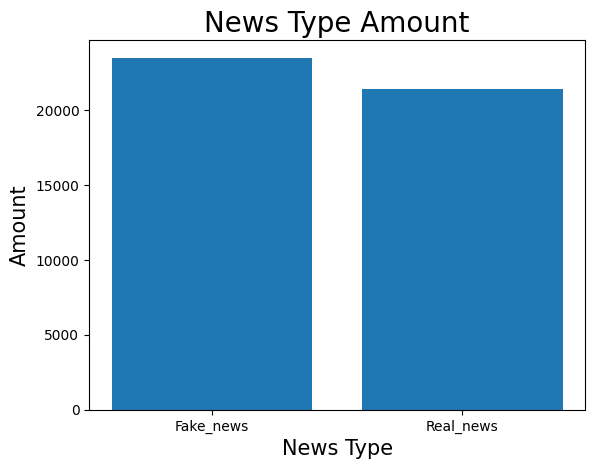

In [44]:
counts = data["class"].value_counts()

plt.bar(["Fake_news", "Real_news"], counts.values)
plt.title("News Type Amount", fontsize= 20)
plt.xlabel("News Type", fontsize=15)
plt.ylabel("Amount", fontsize=15)
plt.show()

In [45]:
# Data cleaning/features engineering.

print("Fake News for obeservation - Text")
print(data.text[0])
print(data["class"][0])
print("\nReal News for observation")
print(data.text[1])
print(data["class"][1])

Fake News for obeservation - Text
21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to the rhetoric of the leftist media and pundits who neglect to note that no court has ever blocked any Presidential orders in immigration in the past or discuss the legal efficacy of the halt or the actual text of the Executive Order.READ MORE TRUMP NEWS AT: 21st Century Wire Trump Files

In [46]:
# Adding length of news before removing non-essentials.
data["len_with_stpwds"] = data["text"].apply(lambda x: len(x))

# Viewing data with text lengths
data.head()

,text,class,len_with_stpwds
0,"21st Century Wire says Ben Stein, reputable pr...",0,1028
1,WASHINGTON (Reuters) - U.S. President Donald T...,1,4820
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1,1848
3,"On Monday, Donald Trump once again embarrassed...",0,1244
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1,3137


In [47]:
# Checking if text length has any effect on the probability of a news piece being true or false

len_class = data.groupby("class")["len_with_stpwds"].mean()
print(len_class)

class
0    2547.396235
1    2383.278517
Name: len_with_stpwds, dtype: float64


> Based on the result of the analysis, there is no real difference between the length of fake or real news therefore, the column will be dropped.

In [48]:
data.drop("len_with_stpwds", axis= 1, inplace = True)

In [49]:
data.head()

,text,class
0,"21st Century Wire says Ben Stein, reputable pr...",0
1,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,"On Monday, Donald Trump once again embarrassed...",0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [50]:
# Text formatting: lowering text cases, removal of punctuations, removal of nubers.

# Turning text to lower case
data["formatted_text"] = data["text"].apply(lambda x: x.lower())

# Removal of numnbers
data["formatted_text"] = data["formatted_text"].apply(lambda x: re.sub(r'[0-9]+', "", x))

# Removal of punctuations, symbols and whitespaces
data["formatted_text"] = data["formatted_text"].apply(lambda x: x.replace(",", " ").replace(":", " ").replace(".", "")
.replace("'", " ").replace("%", " ").replace(";", " ").replace("/", " ").replace('"', " ").replace("(", " ")
.replace(")", " ").replace("!", " ").replace("+", " ").replace("@", " ").replace("*", " ").replace("$", " ")
.replace("&", " ").replace("-", " ").replace("?", " ").replace("#", " ").replace("[", " ").replace("]", " ")
.replace("“", " ").replace("”", " ").replace(r"‘", " ").replace(r"’", " ").replace("'", " ")
.replace("  ", " ").replace("    ", " ").replace("_", " ").replace("\n", " ").replace("`", " ").replace("\t", " "))

data.head()

,text,class,formatted_text
0,"21st Century Wire says Ben Stein, reputable pr...",0,st century wire says ben stein reputable profe...
1,WASHINGTON (Reuters) - U.S. President Donald T...,1,washington reuters us president donald trump ...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1,reuters puerto rico governor ricardo rossell...
3,"On Monday, Donald Trump once again embarrassed...",0,on monday donald trump once again embarrassed ...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1,glasgow scotland reuters most us presidential...


In [51]:
# Instantiation of stemmer and english stopwords
eng_stop_words = stopwords.words("english")
stemmer = PorterStemmer()


# Removal of stopwords, stemming and removal of words with insignificant length
data["formatted_text"] = data["formatted_text"].apply(lambda x: " ".join([stemmer.stem(word.strip()) for word in x.split() if word not in eng_stop_words if len(word) >= 3]))

In [3]:
# Saving cleaned and stemmed version of data
# data.to_csv("Dataset/clean_data.csv", index=False)
# Reading in stemmed version
data = pd.read_csv("Dataset/clean_data.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
data.head()

,text,class,formatted_text
0,"21st Century Wire says Ben Stein, reputable pr...",0,centuri wire say ben stein reput professor pep...
1,WASHINGTON (Reuters) - U.S. President Donald T...,1,washington reuter presid donald trump remov ch...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1,reuter puerto rico governor ricardo rossello s...
3,"On Monday, Donald Trump once again embarrassed...",0,monday donald trump embarrass countri accident...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1,glasgow scotland reuter presidenti candid abro...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            44898 non-null  object
 1   class           44898 non-null  int64 
 2   formatted_text  44266 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
data.isnull().sum()

text                0
class               0
formatted_text    632
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data.isnull().sum()

text              0
class             0
formatted_text    0
dtype: int64

In [12]:
# Combining every Real news and Fake news into two distinct one to calculate count vectors of top words in real and fake news.

# All reviews grouped by class
all_formatted_text = data.groupby("class")["formatted_text"]

# Extraction of distinct groups (Series)
fake_news_series = all_formatted_text.get_group(0)
real_news_series = all_formatted_text.get_group(1)

# Creating lists containing all news
fake_news_list = [news for news in fake_news_series]
real_news_list = [news for news in real_news_series]
all_news_list = fake_news_list + real_news_list

# Creating string containing all words in each news type
fake_news_string = " ".join(fake_news_list)
real_news_string = " ".join(real_news_list)

In [22]:
news_dictionary = {
    "fake": fake_news_string,
    "real": real_news_string
}

# Dataframe of all strings
news_class_frame = pd.DataFrame(news_dictionary, index=["news_text"])

In [37]:
news_class_frame = news_class_frame.head().T
news_class_frame.head()

,news_text
fake,centuri wire say ben stein reput professor pep...
real,washington reuter presid donald trump remov ch...


In [109]:
# Calculating text frequencies
transformer = TfidfVectorizer(ngram_range=(1,2))
news_transformer = transformer.fit_transform(news_class_frame["news_text"])


# making a dataframe that contains all feature names and frequencies in order to determine new possible stop words.
document_term_freq_df = pd.DataFrame(news_transformer.toarray(), columns= transformer.get_feature_names_out(), index=["fake", "real"])
document_term_freq_df = document_term_freq_df.T.sort_values(by= ["fake", "real"], ascending=False)
document_term_freq_df.head()

,fake,real
trump,0.436805,0.286334
said,0.177470,0.517953
presid,0.167065,0.157512
peopl,0.148863,0.080272
one,0.139865,0.071905


In [117]:
# Saving model as pickle file.
pickle.dump(transformer, open("news-transformer.pkl", "wb"))

> Based on the information above, the word **"trump"** is used a lot in both real and fake news however, not nearly as often therefore, it will not be placed as a stopword and other words are also not used nearly as often in both real and fake news.

## List of data pre-processing/feature engineering steps taken.
- Turning texts into lower case.
- Removal of numbers.
- Removal of symbols, special characters and white spaces.
- Removal of stopwords (english).
- stemming of words.
- Text transformation using TF-IDF Vectorizer.

In [118]:
# Splitting data into train and test sets
x = data["formatted_text"]
x = transformer.transform(x)
y = data["class"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [102]:
# Model training 

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [126]:
# Saving model as pickle file
pickle.dump(model, open("pred-model.pkl", "wb"))

## Model Evaluation

In [125]:
from sklearn.metrics import accuracy_score

# Predicting test dataset
test_predictions = model.predict(x_test)
test_score = accuracy_score(y_test, test_predictions)

train_predictions = model.predict(x_train)
train_score = accuracy_score(y_train, train_predictions)

# Printing results
print(f"The accuracy on Test data is {round(test_score, 4)}%")
print(f"The accuracy on Training data is {round(train_score, 4)}%")

The accuracy on Test data is 0.9994%
The accuracy on Training data is 0.9995%


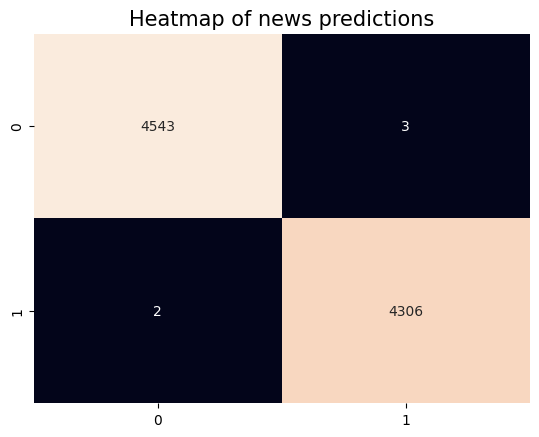

In [136]:
# Confusion matric plotting
confusion_mat = confusion_matrix(y_test, test_predictions)
sns.heatmap(confusion_mat, annot=True, fmt="d", cbar=False)
plt.title("Heatmap of news predictions", fontsize=15)
plt.show()

## Final findings/summary

- The model performs well on both training and test data with no huge difference therefore, The model is good.

In [10]:
import pickle

model = pickle.load(open("news-transformer.pkl", "rb"))
model_2 = pickle.load(open("pred-model.pkl", "rb"))
text = ["This system is a conjunction of AI and NLP (Natural Language prediction) for fake news prediction. It employs the use of machine learning model trained with labeled data to classify news in these two broad categories: Real and Fake news."]

res = model.transform(text)
model_2.predict(res)

array([0], dtype=int64)